<h2 style='color:blue' align='center'>Data Augmentation To Address Overfitting In Flower Classification CNN</h2>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Load data

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it
data_dir

228818944/228813984 [==============================] - 2s 0us/step


'./datasets/flower_photos'

## Data Exploration

In [3]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [4]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/dandelion/17420983523_2e32d70359.jpg'),
 PosixPath('datasets/flower_photos/dandelion/3509307596_6cfe97867d_n.jpg'),
 PosixPath('datasets/flower_photos/dandelion/9533964635_f38e6fa3c3.jpg'),
 PosixPath('datasets/flower_photos/dandelion/7040710179_7f86a17a3c_n.jpg'),
 PosixPath('datasets/flower_photos/dandelion/3761310831_41b5eba622_n.jpg')]

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [6]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/20622485918_90fc000c86_n.jpg'),
 PosixPath('datasets/flower_photos/roses/9164924345_6b63637acf.jpg'),
 PosixPath('datasets/flower_photos/roses/16078501836_3ac067e18a.jpg'),
 PosixPath('datasets/flower_photos/roses/3663244576_97f595cf4a.jpg'),
 PosixPath('datasets/flower_photos/roses/174109630_3c544b8a2f.jpg')]

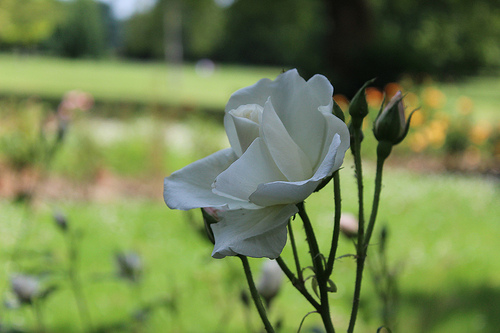

In [7]:
PIL.Image.open(str(roses[1]))

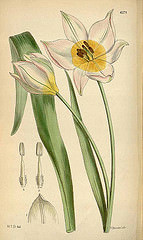

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

# Read flowers images from disk into numpy array using opencv

In [9]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [10]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [11]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])
X = np.array(X)
y = np.array(y)

## Train test split

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [13]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

# Build convolutional neural network and train it

In [15]:
num_classes = 5

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=10)    

Epoch 1/10
86/86 [==============================] - 1s 14ms/step - loss: 1.4602 - accuracy: 0.4095
Epoch 2/10
86/86 [==============================] - 1s 14ms/step - loss: 1.0325 - accuracy: 0.6032
Epoch 3/10
86/86 [==============================] - 1s 14ms/step - loss: 0.8591 - accuracy: 0.6773
Epoch 4/10
86/86 [==============================] - 1s 14ms/step - loss: 0.6788 - accuracy: 0.7413
Epoch 5/10
86/86 [==============================] - 1s 14ms/step - loss: 0.4544 - accuracy: 0.8368
Epoch 6/10
86/86 [==============================] - 1s 14ms/step - loss: 0.2761 - accuracy: 0.9077
Epoch 7/10
86/86 [==============================] - 1s 14ms/step - loss: 0.1930 - accuracy: 0.9357
Epoch 8/10
86/86 [==============================] - 1s 14ms/step - loss: 0.0948 - accuracy: 0.9727
Epoch 9/10
86/86 [==============================] - 1s 15ms/step - loss: 0.0400 - accuracy: 0.9909
Epoch 10/10
86/86 [==============================] - 1s 15ms/step - loss: 0.0196 - accuracy: 0.9960


In [16]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 0s 9ms/step - loss: 1.9753 - accuracy: 0.6362


[1.975314974784851, 0.6361655592918396]

# Improve Test Accuracy Using Data Augmentation

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(180, 
                                                              180,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

### Original Image

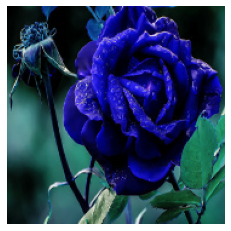

In [21]:
plt.axis('off')
plt.imshow(X[14])

### Newly generated training sample using data augmentation

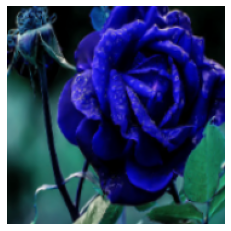

In [22]:
plt.axis('off')
plt.imshow(data_augmentation(X)[14].numpy().astype("uint8"))

# Train the model using data augmentation and a drop out layer

In [25]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=30)  

Epoch 1/30
86/86 [==============================] - 1s 17ms/step - loss: 1.4126 - accuracy: 0.3841
Epoch 2/30
86/86 [==============================] - 1s 17ms/step - loss: 1.0658 - accuracy: 0.5759
Epoch 3/30
86/86 [==============================] - 1s 17ms/step - loss: 0.9529 - accuracy: 0.6319
Epoch 4/30
86/86 [==============================] - 1s 17ms/step - loss: 0.8742 - accuracy: 0.6577
Epoch 5/30
86/86 [==============================] - 1s 17ms/step - loss: 0.8415 - accuracy: 0.6791
Epoch 6/30
86/86 [==============================] - 1s 17ms/step - loss: 0.7851 - accuracy: 0.6879
Epoch 7/30
86/86 [==============================] - 1s 17ms/step - loss: 0.7422 - accuracy: 0.7057
Epoch 8/30
86/86 [==============================] - 1s 17ms/step - loss: 0.7303 - accuracy: 0.7158
Epoch 9/30
86/86 [==============================] - 1s 17ms/step - loss: 0.6962 - accuracy: 0.7304
Epoch 10/30
86/86 [==============================] - 1s 17ms/step - loss: 0.6488 - accuracy: 0.7467
Epoch 11/

In [26]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 0s 8ms/step - loss: 0.7806 - accuracy: 0.7462


[0.7806492447853088, 0.7461873888969421]